I wrote a series of linear regression classes that performs simple linear regression via matrix inversion

In [1]:
import sys
sys.path.append('./code')

%matplotlib inline
import numpy as np
from statfunctions import *
import statfunctions
reload(statfunctions)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erf, erfinv
sns.set_style('white')
sns.set_context('poster')
import re

Generate some random data and fit it to polynomials. Here, I am printing out the results of the fitting

In [2]:
x  = [np.linspace(-1,1,100), np.linspace(-.5,1.5,25), np.linspace(-.75, 1.25, 15)]
dy = [(1 + x[0]**2) * np.ones(x[0].shape)/10, (1 + 3*x[1]**2)*np.ones(x[1].shape)/10, (1 + x[2]**2) * np.ones(x[2].shape)/5]
labels = ['curve a', 'curve b', 'curve c']

y = [dy[0] * np.random.normal(size = x[0].shape) + x[0],
     dy[1] * np.random.normal(size = x[1].shape) + x[1]**2 - 2,
     dy[2] * np.random.normal(size = x[2].shape) + x[2]**3/3 -.5 - x[2]]


regrs = [statfunctions.PolynomialFit1D(x[i], y[i], dy[i], order=2, label=labels[i]) for i in range(len(y))]

for regr in regrs:
    print regr

::::::::::::::::::::::::: REGRESSION MODEL :::::::::::::::::::::::::

label:		curve a

type:		1d polynomial linear regression with 3 parameters

model:		y = a(0) + a(1)x + a(2)x^2

chi^2:		(1.27+/-0.14)

coefficients:

  names units     value    dvalue  significance   p(zero)
0  a(0)        0.011153  0.016706      0.667604  0.878261
1  a(1)        1.003826  0.026373     38.062360  0.000000
2  a(2)        0.025141  0.049183      0.511179  0.940327
::::::::::::::::::::::::: REGRESSION MODEL :::::::::::::::::::::::::

label:		curve b

type:		1d polynomial linear regression with 3 parameters

model:		y = a(0) + a(1)x + a(2)x^2

chi^2:		(0.75+/-0.3)

coefficients:

  names units     value    dvalue  significance       p(zero)
0  a(0)       -2.025738  0.036619     55.319322  0.000000e+00
1  a(1)        0.186289  0.119316      1.561307  3.149240e-01
2  a(2)        0.923204  0.165550      5.576572  7.359117e-08
::::::::::::::::::::::::: REGRESSION MODEL :::::::::::::::::::::::::

label:		curve

Plot all of the datasets along with the fit functions and error regions

C:\Anaconda\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


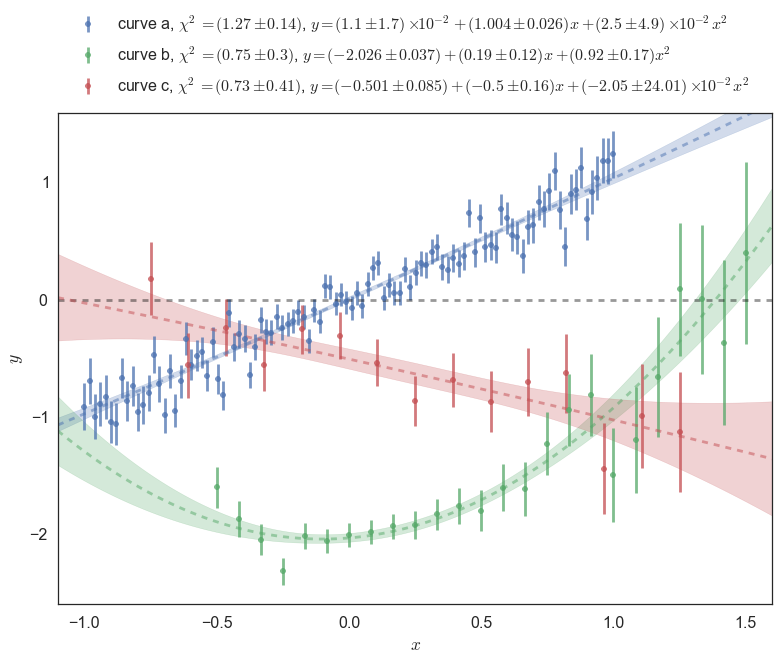

In [3]:
regression_plot(regrs, legend=True, fit_expression=True, max_label_length=115)

Plot the same thing, but in separate subplot windows

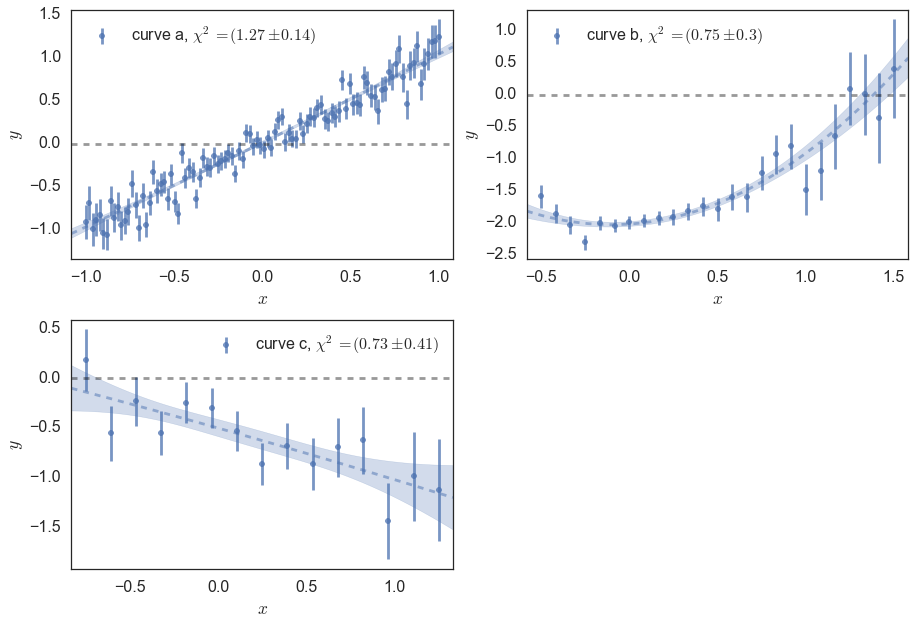

In [4]:
plt.figure()
for i in range(len(regrs)):
    plt.subplot(2,2,i+1)
    regrs[i].plot(fit_expression=False)
plt.tight_layout()

create a t-distribution for the fit to the model function

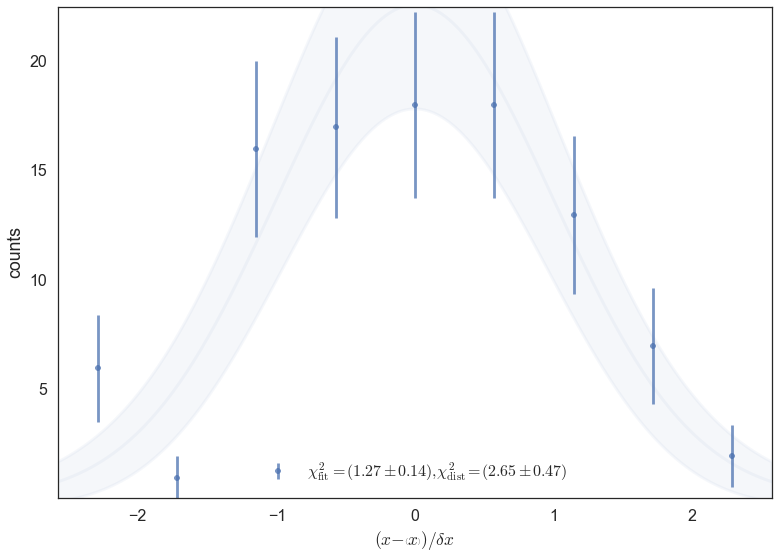

In [5]:
regrs[0].histogram()

In [6]:
class KernelEstimator1D(object):
    
    def __init__(self, x, y, dy=None, width=None, order=None, 
                 method='smooth', kernel='normal', renormalize_error=False):
        
        if width is None:
            width = 3 * (max(x) - min(x)) / len(x)
            
        if dy is None:
            dy = np.ones(y.shape)
            
        #save the data
        self.x = x
        self.y = y
        self.dy = dy
        
        # this is the polynomial order that is used for polynomial local regression
        self.order = order
        
        #save the model method
        self.width = width
        self.kernel = self.get_kernel_function(kernel)
        self.method = self.get_method_function(method)
         
        #evaluate the best fit value with this method:
        self.y_est, self.dy_est = self.evaluate(self.x)
        
        self.chi2, self.dchi2 = chi_squared(self.y_est - self.y, self.dy, ddof=0)
        
        if renormalize_error:
            self.renormalize_error()
    
    def __str__(self):
        pass
        
    def __repr__(self):
        pass
        
        
    def evaluate(self, x):
        
        y_est  = []
        dy_est = []
        
        for i in range(len(x)):
            
            y_est_i, dy_est_i = self.method(self.kernel(x[i]), self.x, self.y, self.dy,i)
            
            y_est.append(y_est_i)
            dy_est.append(dy_est_i)
            
        return np.array(y_est), np.array(dy_est)
        
    
    def renormalize_error(self):
        self.dy *= np.sqrt(self.chi2)
        self.dy_est *= np.sqrt(self.chi2)
        self.dchi2 /= self.chi2
        self.chi2 = 1
        
        
    def get_kernel_function(self, kernel):
        """
        returns a kernel function vs x.
        """
        
        u = lambda x: (self.x - x) / self.width
        square = lambda x: (u(x) >= -1) * (u(x) <= 1)
        
        if kernel == 'uniform':
            return lambda x: (1 / 2.) * square(x)
        elif kernel == 'triangular':
            return lambda x: (1 - np.abs(u(x))) * square(x)
        elif kernel in ['epanechnikov', 'quadratic']:
            return lambda x: (3 / 4.) * (1 - (u(x))**2) * square(x)
        elif kernel in ['biweight', 'quartic']:
            return lambda x: (15 / 16.) * (1 - (u(x))**2)**2 * square(x)
        elif kernel == 'triweight':
            return lambda x: (35 / 32.) * (1 - (u(x))**2)**3 * square(x)
        elif kernel == 'tricube':
            return lambda x: (70 / 81.) * (1 - (np.abs(u(x)))**3)**3 * square(x)
        elif kernel in ['gaussian', 'normal']:
            return lambda x: (1 / np.sqrt(2 * np.pi)) * np.exp(-(u(x))**2/2.)
        elif kernel == 'cosine':
            return lambda x: (np.pi / 4.) * np.cos((np.pi / 2.) * u(x)) * square(x)
        elif kernel == 'logistic':
            return lambda x: 1 / (np.exp(u(x)) + 2 + np.exp(-u(x)))
        elif kernel == 'silverman':
            return lambda x: ((1 / 2.) * np.exp(-np.abs(u(x))/np.sqrt(2)) *
                              np.sin(np.abs(u) / np.sqrt(2) + np.pi / 4.))
        else:
            IOError('the kernel type that you requested is invalid.')
            
    def get_method_function(self, method):
        
        if method in ['smooth', 'constant']:
            def smooth(k, x, y, dy, i):
                norm   = np.sum(k / dy**2)
                y_est  = np.sum(k * y / dy**2) / norm
                dy_est = np.sqrt(np.sum(k**2 / dy**2)) / norm
                return y_est, dy_est
            
            return smooth
        elif method in ['polynomial', 'linear', 'quadratic', 'cubic']:
            if method == 'linear':
                order = 1
            elif method == 'quadratic':
                order = 2
            elif method == 'cubic':
                order = 3
            elif method == 'polynomial':
                if self.order is None:
                    raise IOError('for polynomial regression, you must enter an order')
                else:
                    order = self.order
            
            def local_linear_regression(k, x, y, dy, i):
                
                x_function  = [x**i for i in range(order + 1)]
                weights     = k /  dy**2
                
                coefficients, dcoefficients, covariance = linear_regression(x_function, y, dy)
                
                y_est, dy_est = evaluate_linear_regression_model(coefficients, dcoefficients, covariance)
                
                return y_est[i], dy_est[i]
            
            return local_linear_regression
                

Here are two ways to perform the same linear regression operation:

::::::::::::::::::::::::: REGRESSION MODEL :::::::::::::::::::::::::

label:		line fit

type:		1d polynomial linear regression with 2 parameters

model:		x = a(0) + a(1)t

chi^2:		(1+/-0.25)

coefficients:

  names units     value    dvalue  significance  p(zero)
0  a(0)     s -5.065430  0.188253     26.907527        0
1  a(1)        3.072865  0.315371      9.743660        0


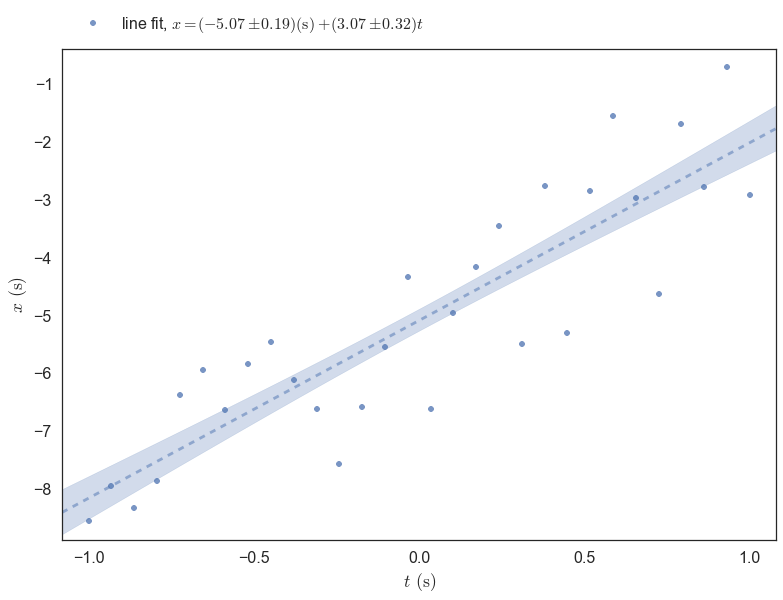

In [7]:
N = 30

x = np.linspace(-1,1,N)
y = np.random.normal(size=(N,)) +3 * x - 5

regr_poly = statfunctions.PolynomialFit1D(x, y, order=1, 
                            label='line fit',
                            x_name='t',
                            y_name='x',
                            x_unit='s',
                            y_unit='m')
print regr_poly

regr_poly.plot()

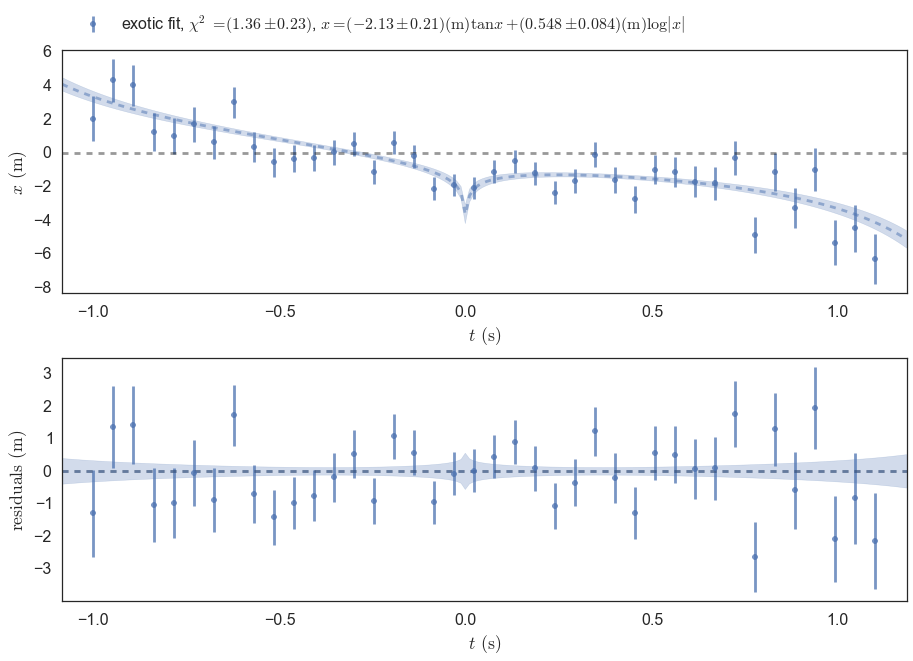

In [8]:
N =40

x = np.linspace(-1,1.1,N)
dy = (1 + x**2) * np.ones(x.shape)/1.5
y = dy*np.random.normal(size=(N,)) - 2 * np.tan(x) + .5 * np.log(np.abs(x))
model = lambda x: np.array([np.tan(x), np.log(np.abs(x))])

regr_gen  =  statfunctions.LinearRegression1D(x, y, dy, model_function=model, 
                                                label='exotic fit',
                                                x_name='t',
                                                y_name='x',
                                                x_unit='s',
                                                y_unit='m',
                                                basis_names=['\\tan{x}', '\\log{|x|}'],
                                                coefficient_units=['m', 'm'])

plt.figure()
plt.subplot(2,1,1)
regr_gen.plot()
plt.subplot(2,1,2)
regr_gen.plot(residuals=True, legend=False, fit_expression=False)
plt.tight_layout()

::::::::::::::::::::::::: REGRESSION MODEL :::::::::::::::::::::::::

label:		sine fit

type:		1d sinusoidal linear regression with 4 parameters

model:		x = c(0) + s(1)\sin{(\omega_{1} t)} + c(1)\cos{(\omega_{1} t)} + s(2)\sin{(\omega_{2} t + \phi_{2})}

chi^2:		(0.92+/-0.31)

coefficients:

  names units     value    dvalue  significance   p(zero)
0  c(0)     m  0.148939  0.342153      0.435299  0.987155
1  s(1)     m -0.150393  0.496445      0.302939  0.996788
2  c(1)     m -1.141029  0.451300      2.528319  0.045062
3  s(2)     m  0.780498  0.474878      1.643578  0.344668


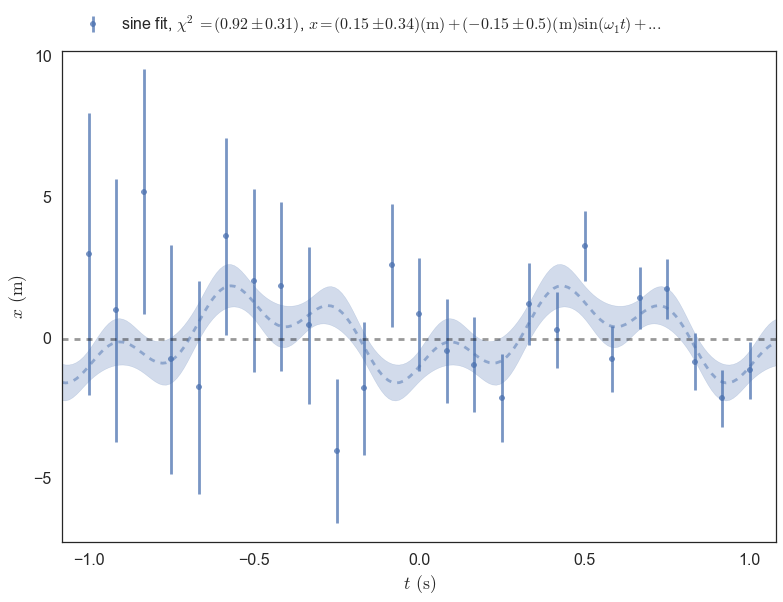

In [9]:
N = 25

x = np.linspace(-1,1,N)
dy = (1 + (x - 1)**2)* np.ones(x.shape)
y = (dy * np.random.normal(size=(N,)) + .5 +
     np.sin(2 * np.pi * x) - np.cos(2 * np.pi * x) 
     + np.sin(2 * np.pi * 3 * x))


regr_sine = statfunctions.SineFit1D(x, y, dy, frequencies=[1, 3],
                            phases=[None, 0],
                            offset=True,
                            label='sine fit',
                            x_name='t',
                            y_name='x',
                            x_unit='s',
                            y_unit='m')
print regr_sine

regr_sine.plot()

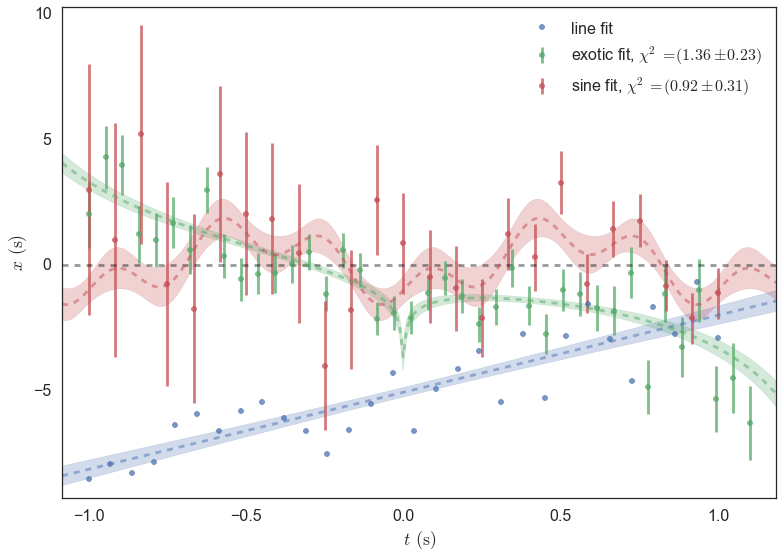

In [10]:
regression_plot([regr_poly, regr_gen, regr_sine], legend=True)

### removing outliers

Here is a some data that follows the functional behavior of a line. The data is mostly normally distributed, but a small fraction of the data is lorentzian distributed that results in large outlier values. Here, I used a interative approach to remove outliers from the data

::::::::::::::::::::::::: REGRESSION MODEL :::::::::::::::::::::::::

label:		line fit

type:		1d polynomial linear regression with 2 parameters

model:		x = a(0) + a(1)t

chi^2:		(8.5000+/-0.0010)x10^(2)

coefficients:

  names units     value    dvalue  significance  p(zero)
0  a(0)     s  2.186341  0.070711     30.919527        0
1  a(1)        4.784716  0.121864     39.262871        0


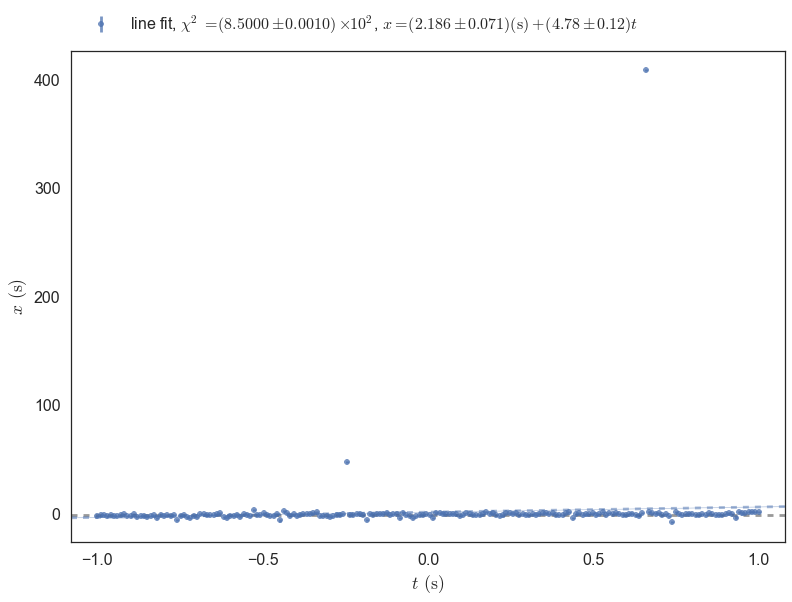

In [11]:
N = 200

x = np.linspace(-1,1,N)
noise = np.append(np.random.standard_cauchy(size=(N/4,)), np.random.normal(size=(3*N/4,)))
noise = noise.flatten()
noise = noise[np.random.permutation(N)]
y = noise + x
dy = np.ones(N)

regr = statfunctions.PolynomialFit1D(x, y, dy=dy, order=1, 
                                            label='line fit',
                                            x_name='t',
                                            y_name='x',
                                            x_unit='s',
                                            y_unit='m')
print regr

regr.plot()

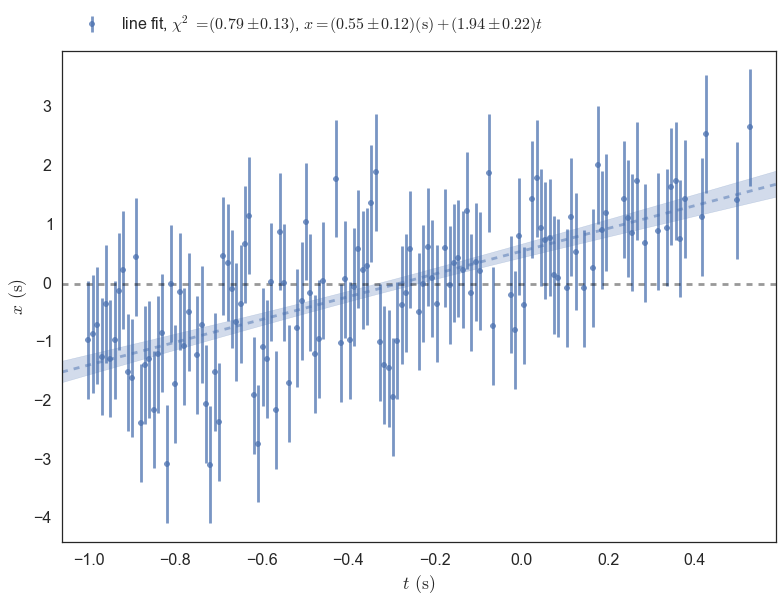

In [12]:
regr.remove_outliers()
regr.plot()

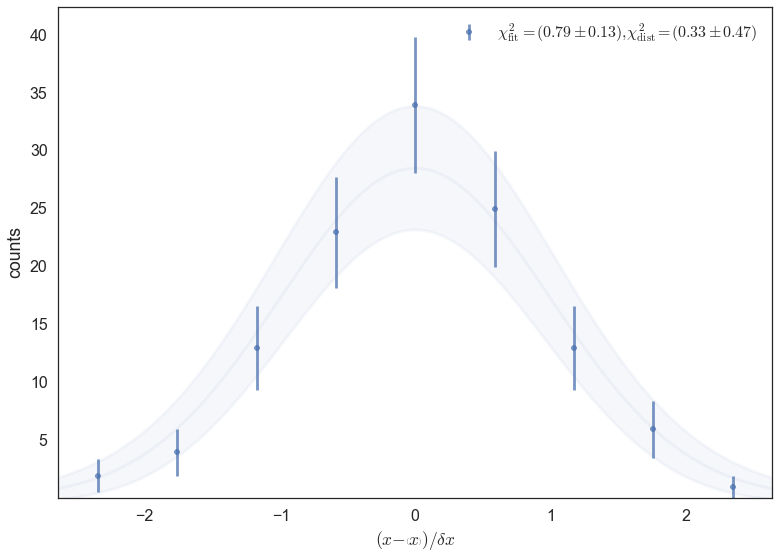

In [13]:
regr.histogram()

I included the capability to include linear constraints on the linear coefficients.

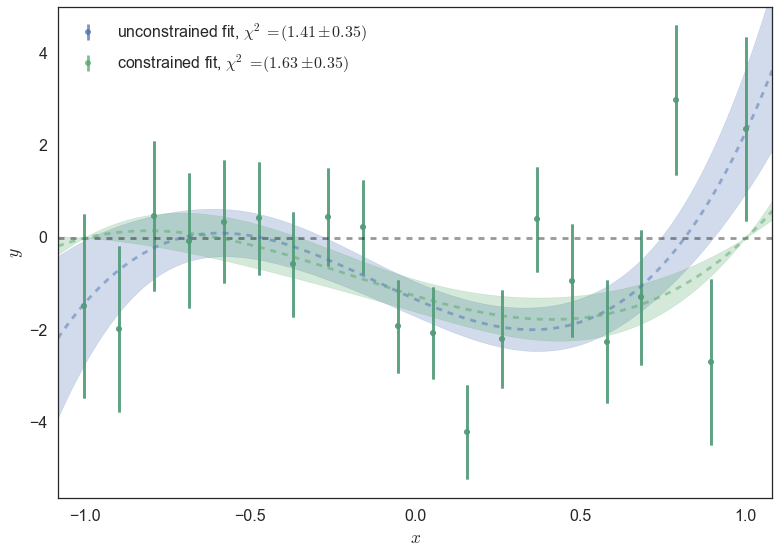

In [14]:
N = 20
x = np.linspace(-1, 1, N)
dy = (1 + x**2) * np.ones(N)
y = dy * np.random.normal(size=(N,)) + (x - 1) * (x + 1)**2

order = 3

constraints = [([1 for i in range(order + 1)], 0),
               ([(-1)**i for i in range(order + 1)], 0)]

regr_unconstrained = statfunctions.PolynomialFit1D(x, y, dy, 
                                                   order=order, 
                                                   label='unconstrained fit')
regr_constrained   = statfunctions.PolynomialFit1D(x, y, dy, 
                                                   order=order, 
                                                   label='constrained fit', 
                                                   constraints=constraints)

statfunctions.regression_plot([regr_unconstrained, 
                               regr_constrained], 
                               legend=True)

Here, we can show that the uncertainties provided on these coefficients obtained from the constrained fit are valid:

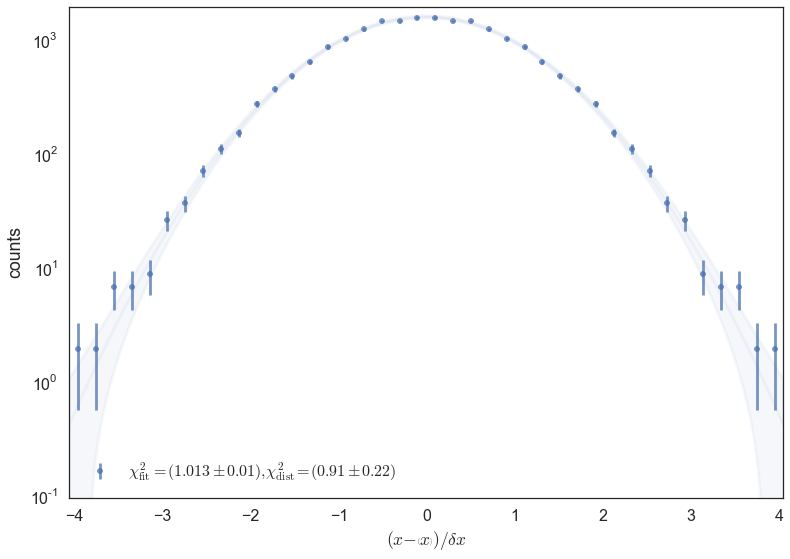

In [15]:
reps = 5000

coeffs  = []
dcoeffs = []

for i in range(reps):

    N = 250
    x = np.linspace(-1, 1, N)
    dy = (1 + x**2) * np.ones(N)
    y = dy * np.random.normal(size=(N,)) + 1 - 1. * x - 1. * x**2 + 2 * x**3

    order = 3

    constraints = [([1 for i in range(order + 1)], 1),
                   ([int(i < 2) for i in range(order + 1)], 0)]

    regr_constrained   = statfunctions.PolynomialFit1D(x, y, dy, 
                                                       order=order, 
                                                       label='constrained fit', 
                                                       constraints=constraints)
    
    coeffs.append(regr_constrained.coefficients)
    dcoeffs.append(regr_constrained.dcoefficients)
    
coeffs = np.array(coeffs)
dcoeffs = np.array(dcoeffs)

t_hist(coeffs, dcoeffs, axis=0, yscale='log')

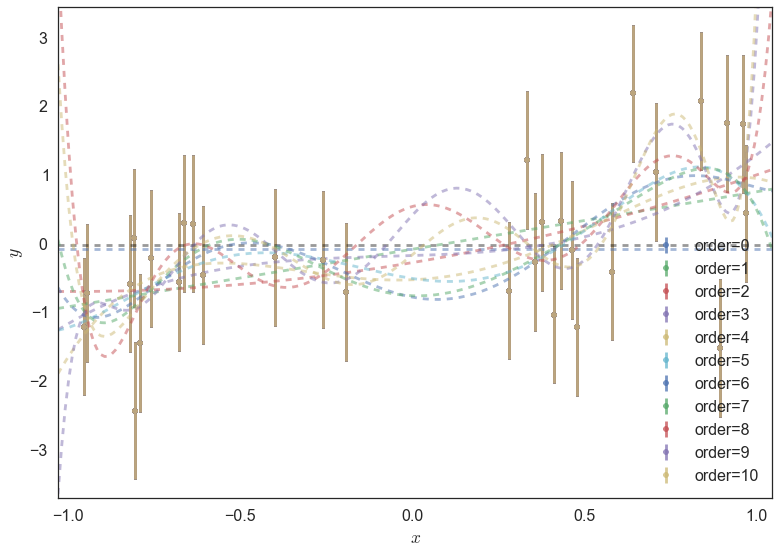

In [20]:
N = 30
x = np.random.rand(N) * 2 - 1
dy = np.ones(N)
y = dy * np.random.normal(size=(N,)) + x
order = 10

regrs = [statfunctions.PolynomialFit1D(x, y, dy, order=i, label=('order=' + str(i))) for i in range(0,order + 1)]
statfunctions.regression_plot(regrs, legend=True, fit_errors=False, chi2=False)

In [21]:
def cross_validataion(self, test_fraction=.75):
    regr = copy.deepcopy(self)

In [22]:
a = np.random.normal(size=(2,2,2))

In [23]:
b = np.split(a,[1],axis=-1)

In [24]:
list(range(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [25]:
print a[:,:,0]
print b[0][:,:,0]

[[-1.66769063 -0.59288714]
 [-0.97451634 -0.06160353]]
[[-1.66769063 -0.59288714]
 [-0.97451634 -0.06160353]]


# Fourier Transform as Linear Regression

Here is a fourier transform linear regression method that can perform the fourier transform on real functions. This is similar to the `np.fft.rfft` in the numpy package. This function, however, propogates errors through the fourier transform, enables variation in uncertainty in each data point, and can handle abnormalities in the data such as jitter in the time dimension (deviation from a uniform sampling rate), or missing data points within a uniform sampling dataset.

The fourier transform linear regression can serve as a method for obtaining a non-parametric fit function as well. A model can be built of the basis functions that correspond to the non-zero fourier components. The cut-off for inclusion can be determined either by a p-value cutoff, or by using a cross-validation method.

First, here is an example of the fourier transform of a sum of two cosine functions at different frequency with noise. The fourier transform can be thought of as a fit function with the number of degrees of freedom equal to that of the dataset resulting in a fit function that matches the mean  value and uncertainties of every datapoint. I am showing a comparison here between the results from the Linear Regression Fourier Transform (LRFT) and the Real Fast Fourier Transform (RFFT). It is notable that the RFFT is much much faster than the LRFT, but the RFFT does not provide error estimates. The LRFT should be used instead of  the RFFT in the case of small datasets, or in the case that extraction of meaningful uncertainties is critical.

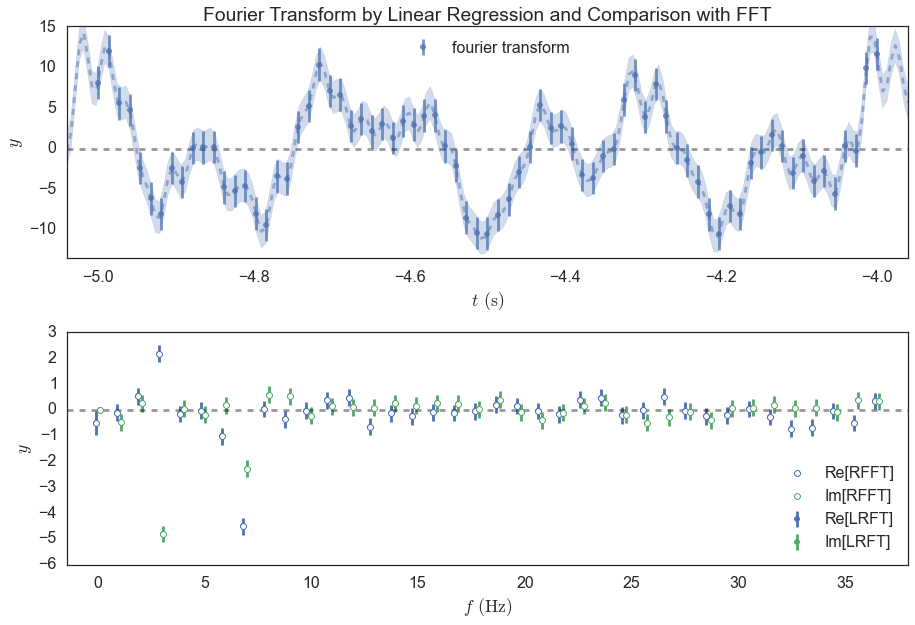

In [42]:
reload(statfunctions)
N = 75
x = np.linspace(0, 1, N) - 5
dy = np.ones(N) * 2
y = dy * np.random.normal(size=(N,)) + (5 * np.cos(2 * np.pi * 3 * x) + 
                                        5 * np.cos(2 * np.pi * 7 * x)     )


regr = statfunctions.FourierTransform(x, y, dy, 
                                      x_name='t', x_unit='s', f_unit='Hz',
                                      label='fourier transform')

plt.figure()
plt.subplot(2,1,1)
regr.plot(fit_expression=False, chi2=False)
plt.title('Fourier Transform by Linear Regression and Comparison with FFT')
plt.subplot(2,1,2)
regr.plot_fourier_transform(show_fft=True)
_=plt.legend(loc='best')
plt.tight_layout()

Here is a second example of use of the LRFT. In this case, jitter is added on the sampling time with 

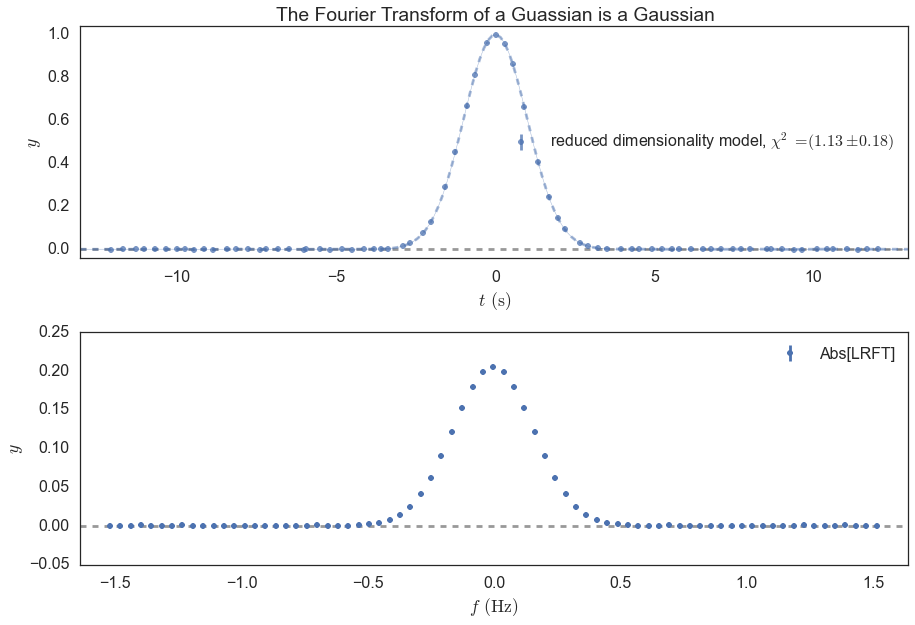

In [43]:
N =75
x_range = 12
x = np.linspace(-x_range, x_range, N) + np.random.normal(size=(N,)) * (2 * x_range) / (float(N)) * .2
dy = np.ones(N) / 1000.0
y = dy * np.random.normal(size=(N,)) + np.exp(-x**2/2.0) #* np.sin(2 * np.pi * 2 * x)

label = 'Fourier Transform of a Modulated Gaussian'

regr = statfunctions.FourierTransform(x, y, dy, label=label, x_name='t', x_unit='s', f_unit='Hz')
regr2 = regr.get_reduced_dimension_model(p=.5, label='reduced dimensionality model')

plt.subplot(2,1,1)
regr2.plot(fit_expression=False)
plt.title('The Fourier Transform of a Guassian is a Gaussian')
plt.subplot(2,1,2)
regr.plot_fourier_transform(show_negative=True, amplitude=True)
plt.legend(loc='best')
plt.tight_layout()

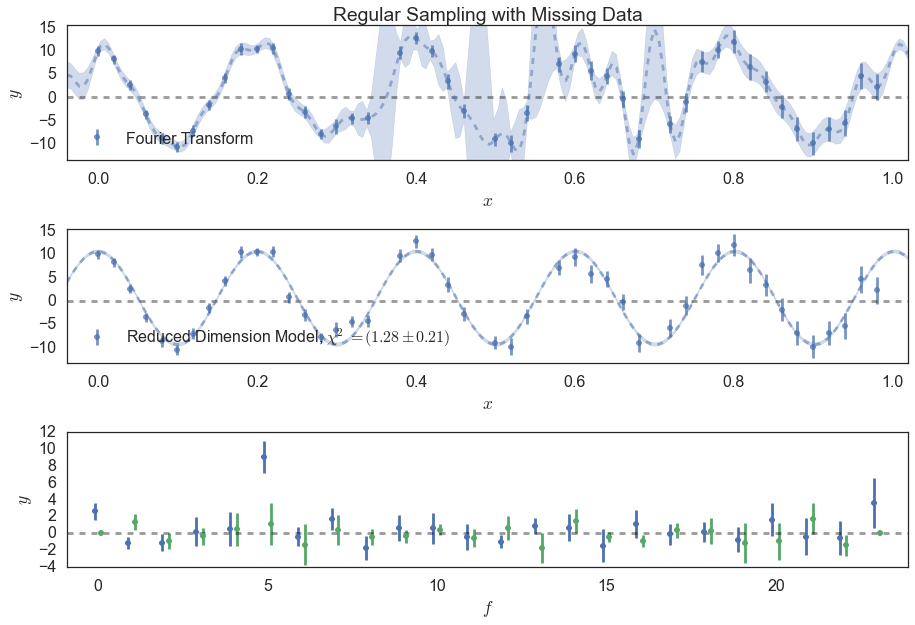

In [44]:
N = 51
n_remove = 5

remove_inds = np.random.permutation(N)[:n_remove]
delete_inds = lambda a: np.delete(a, remove_inds)

x = np.linspace(0, 1, N)
dy = (1 + x**2 * 2 + .15 * np.random.normal(size=(N,))) * np.ones(N)
y = dy * np.random.normal(size=(N,)) + 10 * np.cos(2 * np.pi * 5 * x)

x = delete_inds(x)
y = delete_inds(y)
dy= delete_inds(dy)

regr = statfunctions.FourierTransform(x, y, dy, label='Fourier Transform')
regr2= regr.get_reduced_dimension_model(p=.75, label='Reduced Dimension Model')

plt.subplot(3,1,1)
regr.plot(chi2=False, fit_expression=False)
plt.legend(loc=3)
plt.title('Regular Sampling with Missing Data')
plt.subplot(3,1,2)
regr2.plot(fit_expression=False)
plt.legend(loc=3)
plt.subplot(3,1,3)
regr.plot_fourier_transform()
plt.tight_layout()

Two points define a line, but two points are usually not sufficient to perform a line fit because you have no method to extract the probability distribution for the fit parameters because all of the data was used to extract the coefficients and no data remains to calculate the distribution. However, in the case where you have two points, and you know the distribution that governs those points, it is sufficient to perform a line fit.

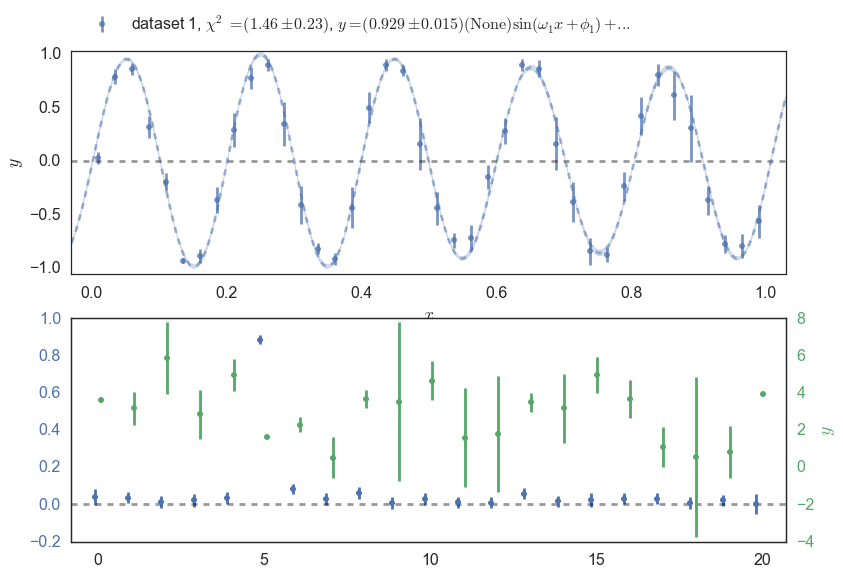

In [45]:
N = 200
x = np.linspace(0, 1, N)
y = np.sin(2*np.pi*5*x + (np.pi/8) * np.random.normal(size=(N,)))
binning = lambda array, bin_size: statfunctions.unweighted_mean(np.reshape(array,(len(array)//bin_size, bin_size)), axis=1)
n = 5
X, dX = binning(x, n)
Y, dY = binning(y, n)

regr = statfunctions.FourierTransform(X, Y, dY)
regr2 = regr.get_reduced_dimension_model()
plt.subplot(2,1,1)
regr2.plot()
plt.subplot(2,1,2)
regr.plot_fourier_transform(amplitude=True, phase=True)

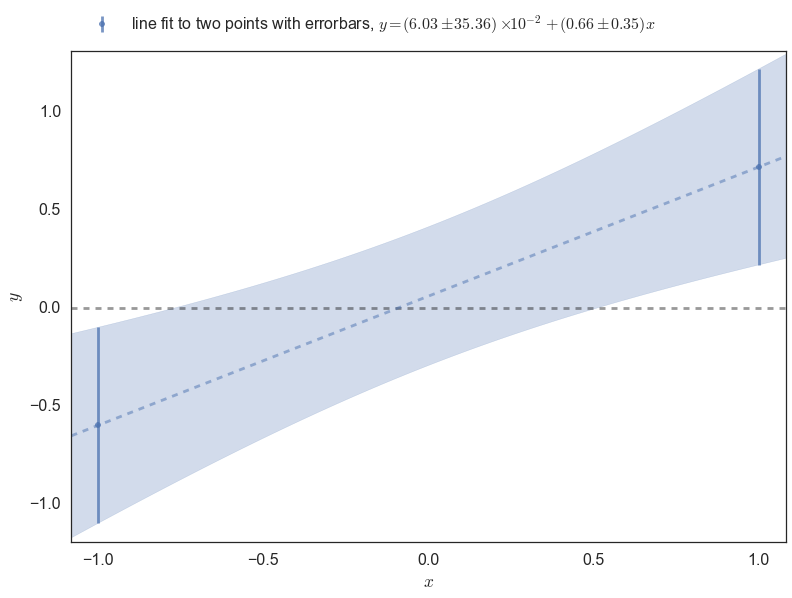

In [46]:
x = np.array([-1, 1])
dy = np.array([.5, .5])
y = dy * np.random.normal(size=x.shape) + x


regr = statfunctions.PolynomialFit1D(x, y, dy, order=1, label='line fit to two points with errorbars')
regr.plot(chi2=False)